# TensorFlow APIs

---

### Listing files in a directory: Plain Python (off-graph)

In [1]:
import glob

glob.glob('my_dir/*')

['my_dir/file_a', 'my_dir/file_b']

### Listing files in a directory: TensorFlow ops (on-graph)

In [2]:
import tensorflow as tf

glob = tf.matching_files('my_dir/*')

session = tf.Session()
session.run(glob)

array(['my_dir/file_a', 'my_dir/file_b'], dtype=object)

For more, see: [Everything in the Graph? Even Glob?](http://planspace.org/20170428-everything_in_the_graph_even_glob/)

For an example of TensorFlow functionality with off-graph and on-graph alternatives, see:
 * [TFRecords for Humans](http://planspace.org/20170323-tfrecords_for_humans/) (off-graph)
 * [Parsing TFRecords inside the TensorFlow Graph](http://planspace.org/20170426-parsing_tfrecords_inside_the_tensorflow_graph/) (on-graph)

---

### Making a Convolutional Layer: Graph Op-Level

In [3]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

weight_initial = tf.truncated_normal([5, 5, 1, 32], stddev=0.1)
weight = tf.Variable(weight_initial)
bias_initial = tf.constant(0.1, shape=[32])
bias = tf.Variable(bias_initial)

convolved = tf.nn.conv2d(x, weight, strides=[1, 1, 1, 1], padding='SAME')
convolved_biased = convolved + bias
y = tf.nn.relu(convolved_biased)

Based on: [Build a Multilayer Convolutional Network](https://www.tensorflow.org/get_started/mnist/pros#build_a_multilayer_convolutional_network)

### Making a Convolutional Layer: Layers

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])

y = tf.layers.conv2d(inputs=x, 
                     filters=32, kernel_size=[5, 5], padding='same', 
                     activation=tf.nn.relu)

Based on: [A Guide to TF Layers: Building a Convolutional Neural Network](https://www.tensorflow.org/tutorials/layers)

### Making a Convolutional Layer: Keras Functional

In [5]:
x = tf.contrib.keras.layers.Input(shape=[28, 28, 1])

y = tf.contrib.keras.layers.Conv2D(filters=32, kernel_size=[5, 5], padding='same',
                                   activation='relu')(x)

### Making a Convolutional Layer: Keras `Sequential`

In [6]:
model = tf.contrib.keras.models.Sequential()

model.add(tf.contrib.keras.layers.Conv2D(filters=32, kernel_size=[5, 5], padding='same',
                                         activation='relu', 
                                         input_shape=[28, 28, 1]))

### More advanced TensorFlow Keras

In [7]:
x = tf.contrib.keras.layers.Input(shape=[28, 28, 1])
residual = x
x = tf.contrib.keras.layers.Activation('relu')(x)
x = tf.contrib.keras.layers.SeparableConv2D(filters=728, kernel_size=[3, 3], padding='same')(x)
x = tf.contrib.keras.layers.BatchNormalization()(x)
y = tf.contrib.keras.layers.add([x, residual])

This is a cartoon of a section from: [xception.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/keras/python/keras/applications/xception.py)

See also: [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)

### Expected around TensorFlow 1.3

In [8]:
# estimator = keras_model.get_estimator()

---

### Simple regression example

Predicting annualized US GDP growth from presidential party. ([data](http://planspace.org/20170505-simple_dataset_us_presidential_party_and_gdp_growth/))

In [9]:
!head -3 president_gdp.csv

term,party,growth
Truman,D,6.57
Eisenhower 1,R,2.72


In [10]:
import numpy as np
import pandas as pd

data = pd.read_csv('president_gdp.csv')
party = data.party == 'D'
party = np.expand_dims(party, axis=1)
growth = data.growth

### Simple regression with `sklearn`

In [11]:
import sklearn.linear_model

model = sklearn.linear_model.LinearRegression()
model.fit(X=party, y=growth)
model.predict([[0], [1]])

array([ 2.54444444,  4.33285714])

### Simple regression with a TensorFlow canned Estimator

In [12]:
# clear old run...
import shutil
shutil.rmtree('tflinreg', ignore_errors=True)

In [13]:
party_col = tf.contrib.layers.real_valued_column(column_name='')

In [14]:
model = tf.contrib.learn.LinearRegressor(feature_columns=[party_col],
                                         model_dir='tflinreg')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x120f61190>, '_model_dir': 'tflinreg', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_master': ''}


In [15]:
model.fit(x=party, y=growth, steps=1000)
list(model.predict(np.array([[0], [1]])))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/Users/aaron/anaconda/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py:254: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tflinreg/model.ckpt.
INFO:tensorflow:loss = 13.2432, step = 1
INFO:tensorflow:global_step/sec: 577.534
INFO:tensorflow:loss = 1.45393, step = 101 (0.175 sec)
INFO:tensorflow:global_step/sec: 598.946
INFO:tensorflow:loss = 1.40094, step = 201 (0.167 sec)
INFO:tensorflow:global_

[2.5422058, 4.3341689]

In [16]:
!tensorboard --logdir tflinreg

Starting TensorBoard 54 at http://phab.local:6006
(Press CTRL+C to quit)
^C


After startup, go to http://localhost:6006/ to see the interface.

To continue with the notebook, interrupt the kernel by using the square "stop" button or by typing esc, i, i.

For more, see:
 * [Simple Regression with a TensorFlow Estimator](http://planspace.org/20170506-simple_regression_with_a_tensorflow_estimator/)
 * [Navigating TensorFlow Estimator Documentation](http://planspace.org/20170521-navigating_tensorflow_estimator_documentation/)
 *  Feature columns, input functions, model functions, experiments, `learn_runner`, and more!

---

### The `Dataset` API

The comparison to the low-level way of doing this is a little involved; for more, see:
 * [TensorFlow documentation on an 8-step data pipeline](https://www.tensorflow.org/programmers_guide/reading_data#reading_from_files)
 * [TensorFlow and Queues](http://planspace.org/20170327-tensorflow_and_queues/)
 * [The TensorFlow Coordinator for Python Threading](http://planspace.org/20170324-the_tensorflow_coordinator_for_python_threading/)
 * [TensorFlow's QueueRunner](http://planspace.org/20170430-tensorflows_queuerunner/)

In [17]:
dataset = tf.contrib.data.TextLineDataset('president_gdp.csv')
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

session = tf.Session()
session.run(next_element)

'term,party,growth'

In [18]:
session.run(next_element)

'Truman,D,6.57'

In [19]:
session.run(next_element)

'Eisenhower 1,R,2.72'

For more, see: [Using the `Dataset` API for TensorFlow Input Pipelines](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data)

---

### Using a pre-trained model with Keras in TensorFlow

In [20]:
model = tf.contrib.keras.applications.InceptionV3()

In [21]:
filename = 'n01882714_4157_koala_bear.jpg'
image = tf.contrib.keras.preprocessing.image.load_img(
    filename, target_size=(299, 299))

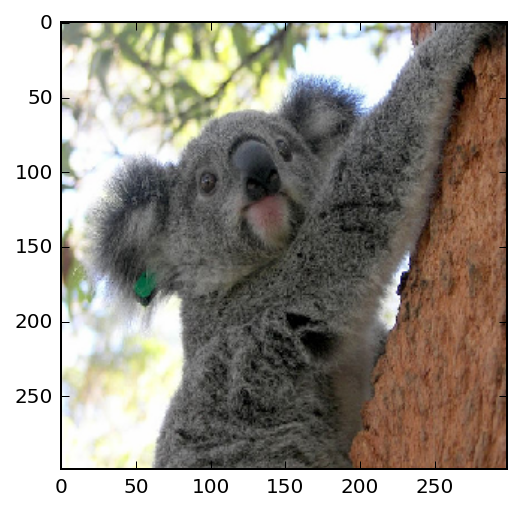

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(image)

In [23]:
array = tf.contrib.keras.preprocessing.image.img_to_array(image)
array = np.expand_dims(array, axis=0)
array = tf.contrib.keras.applications.inception_v3.preprocess_input(array)

In [24]:
probabilities = model.predict(array)

In [25]:
tf.contrib.keras.applications.inception_v3.decode_predictions(probabilities)

[[(u'n01882714', u'koala', 0.9307453),
  (u'n01883070', u'wombat', 0.0022441733),
  (u'n02497673', u'Madagascar_cat', 0.0018795824),
  (u'n02500267', u'indri', 0.00093047676),
  (u'n02128757', u'snow_leopard', 0.0004021546)]]

For more, see: [Pre-trained Models with Keras in TensorFlow](http://planspace.org/20170502-canned_models_with_keras_in_tensorflow/)